In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.colors as mcolors
import datetime

def hex_to_rgb(hex_code):
    hex_code = hex_code.strip("#");lv = len(hex_code);rgb = tuple(int(hex_code[i : i + lv // 3], 16) for i in range(0, lv, lv // 3));return rgb
def rgb_to_dec(rgb):
    return [v / 256 for v in rgb]
def get_continuous_cmap(hex_list, float_list=None):
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list: pass
    else: float_list = list(np.linspace(0, 1, len(rgb_list)))
    cdict = dict()
    for num, col in enumerate(["red", "green", "blue"]): col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]; cdict[col] = col_list
    return mcolors.LinearSegmentedColormap("my_cmp", segmentdata=cdict, N=256)

cmap = get_continuous_cmap(["058d96", "00a450", "52b448", "8ac341"])

In [2]:
from FlYMazeRL.utils import draw_schedule
from FlYMazeRL.utils import generate_random_schedule_with_blocks
from FlYMazeRL.gym.environment import ymaze_static
from FlYMazeRL.agents.neuralnetworks import GQLearner,GRNNLearner
import pandas as pd

action_set = np.loadtxt('https://raw.githubusercontent.com/neurorishika/FlYMazeRL/main/data/action_set.csv',delimiter=',',dtype=np.int32)
reward_set = np.loadtxt('https://raw.githubusercontent.com/neurorishika/FlYMazeRL/main/data/reward_set.csv',delimiter=',',dtype=np.int32)

experiment_size = 200
ensemble_size = 100
K_fold = 3
history_size = 15


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Asymmetric RNN Learners

In [3]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

df = pd.DataFrame(columns=['ModelID','EnsembleID','FoldID','FlyID','MSE(train)','NMSE(train)','LogLikelihood(train)','AIC(train)','BIC(train)','MSE(test)','NMSE(test)','LogLikelihood(test)','AIC(test)','BIC(test)'])

for model_size in [2]:#,3,5,10,50,100
    
    toy_env = ymaze_static(experiment_size)
    
    params = {
        'reservoir_size':model_size,
        'num_layers':1,
        'symmetric_decision_network':False,
        'allow_negative_values':True,
        'omission_is_punishment':False,
        'encoder_size':None,
        'kind':"RNN",
        'policy_type':"softmax",
        'multi_agent': True,
        'n_agents': 100,
    }
    
    param_string=f"{params['reservoir_size']}_{params['num_layers']}_{int(params['symmetric_decision_network'])}{int(params['allow_negative_values'])}{int(params['omission_is_punishment'])}_{int(params['encoder_size']) if params['encoder_size'] is not None else 0}-{params['kind']}_{params['policy_type']}"
    
    model_name = f"{'Symmetric' if params['symmetric_decision_network'] else 'Asymmetric'} ({params['reservoir_size']}-neuron{' with '+params['encoder_size']+'encoders' if params['encoder_size'] is not None else ''}) Deep RNN"

    learner = GRNNLearner(toy_env,params)

    # create K-fold cross validation datasets
    indices = np.arange(len(action_set))
    np.random.shuffle(indices)
    K_folds = np.array_split(indices,K_fold)
    training_sets = []
    validation_sets = []
    for i in range(K_fold):
        training_indices = np.array(list(set(range(len(action_set))) - set(K_folds[i])),dtype=np.int32)
        validation_indices = np.array(K_folds[i],dtype=np.int32)
        training_sets.append({'actions':action_set[training_indices],'rewards':reward_set[training_indices],'indices':training_indices})
        validation_sets.append({'actions':action_set[validation_indices],'rewards':reward_set[validation_indices],'indices':validation_indices})
    
    for ensemble_id in range(ensemble_size):
        # train the model under K-fold cross validation
        for fold_id,(train_set,val_set) in enumerate(zip(training_sets,validation_sets)):
            learner.fit(train_set['actions'],train_set['rewards'],n_replications=1,weight_decay=1e-3,filter_best=False)
            learner.load_pre_trained_model('model_0.pt')

            # evaluate the model
            p_action_train = learner.get_action_probabilities_from_data(train_set['actions'],train_set['rewards'])
            for i,fly_id in enumerate(train_set['indices']):
                obs_actions = train_set['actions'][i][1:]
                obs_action_smooth = np.convolve(obs_actions,np.ones((history_size,))/history_size,mode='full')[history_size-1:]
                pred_action_prob = p_action_train[i,:]
                pred_action_smooth = np.convolve(pred_action_prob,np.ones((history_size,))/history_size,mode='full')[history_size-1:]
                plt.plot(obs_action_smooth,'r',label='Observed')
                plt.plot(pred_action_smooth,'b',label='Predicted')
                plt.show()
                # calculate MSE
                mse_train = np.mean((obs_action_smooth-pred_action_smooth)**2)
                # calculate NMSE by dividing by the variance of the observed action probabilities
                nmse_train = mse_train/np.std(obs_action_smooth**2)
                # calculate bernoulli log likelihood of the actions given the predicted action probabilities
                ll_train = np.sum(np.log(pred_action_prob[obs_actions==1])) + np.sum(np.log(1-pred_action_prob[obs_actions==0]))
                # calculate AIC
                n_params = sum(p.numel() for p in learner.agent.parameters() if p.requires_grad)
                aic_train = -2/len(train_set['actions'][i])*mse_train + 2*n_params
                # calculate BIC
                bic_train = -2/len(train_set['actions'][i])*mse_train + n_params*np.log(len(train_set['actions'][i]))
                # append to dataframe
                df.loc[len(df)] = [model_size,ensemble_id,fold_id,fly_id,mse_train,nmse_train,ll_train,aic_train,bic_train,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN]


            p_action_val = learner.get_action_probabilities_from_data(val_set['actions'],val_set['rewards'])
            for i,fly_id in enumerate(val_set['indices']):
                obs_actions = val_set['actions'][i][1:]
                obs_action_smooth = np.convolve(obs_actions,np.ones((history_size,))/history_size,mode='full')[history_size-1:200]
                pred_action_prob = p_action_val[i,:]
                # calculate MSE
                mse_val = np.mean((obs_action_smooth-pred_action_prob[history_size:])**2)
                # calculate NMSE by dividing by the variance of the observed action probabilities
                nmse_val = mse_val/np.std(obs_action_smooth**2)
                # calculate bernoulli log likelihood of the actions given the predicted action probabilities
                ll_val = np.sum(np.log(pred_action_prob[obs_actions==1])) + np.sum(np.log(1-pred_action_prob[obs_actions]))
                # calculate AIC
                n_params = sum(p.numel() for p in learner.agent.parameters() if p.requires_grad)
                aic_val = -2/len(val_set['actions'][i])*mse_val + 2*n_params
                # calculate BIC
                bic_val = -2/len(val_set['actions'][i])*mse_val + n_params*np.log(len(val_set['actions'][i]))
                # append to dataframe
                df.loc[len(df)] = [model_size,ensemble_id,fold_id,fly_id,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,mse_val,nmse_val,ll_val,aic_val,bic_val]
            

TypeError: init_variables() got an unexpected keyword argument 'symmetric_decision_network'

In [11]:
np.mean(df['NMSE(test)']),np.mean(df['NMSE(train)'])

(0.2199639902793636, 0.21162744740286818)

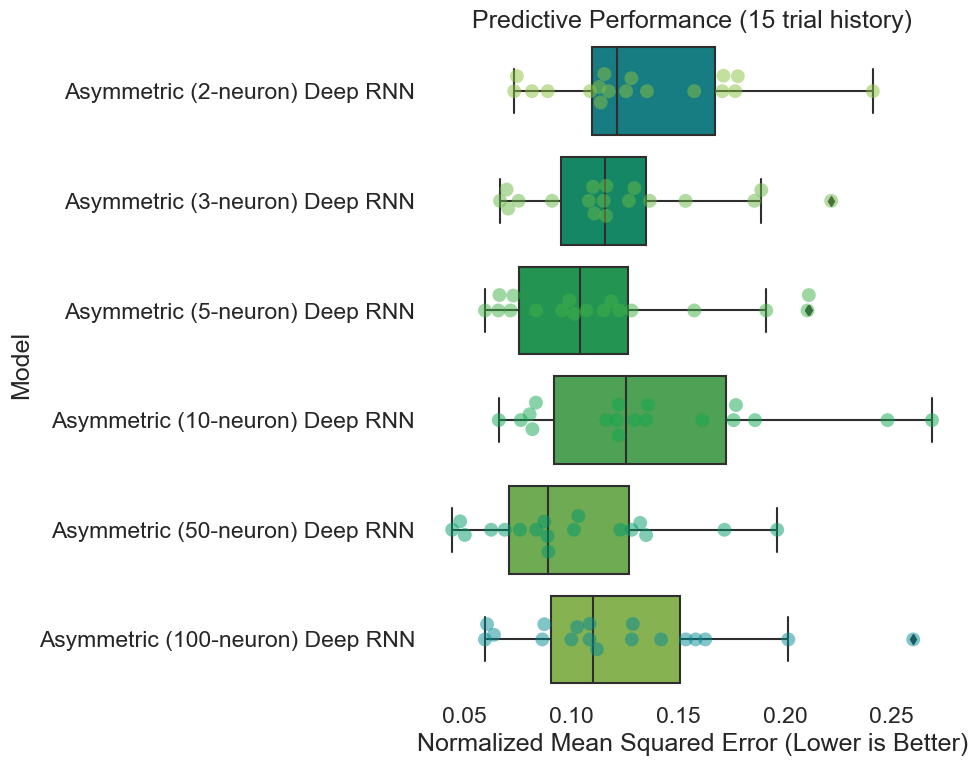

In [26]:
sns.set(style='ticks')
sns.set(font_scale=1.5)
plt.figure(figsize=(10,8))
sns.boxplot(y='Model',x='Normalized Mean Squared Error',data=full_nmse,palette=cmap(np.linspace(0,1,6)))
sns.swarmplot(y='Model',x='Normalized Mean Squared Error',data=full_nmse,palette=cmap(np.linspace(1,0,6)),size=10,alpha=0.5)
plt.box(False)
plt.xlabel('Normalized Mean Squared Error (Lower is Better)')
plt.title('Predictive Performance (15 trial history)')
plt.tight_layout()
plt.savefig('asymmetric_rnn_predictive_performance_15.png',dpi=300,transparent=True)

# Symmetric RNN Learners

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


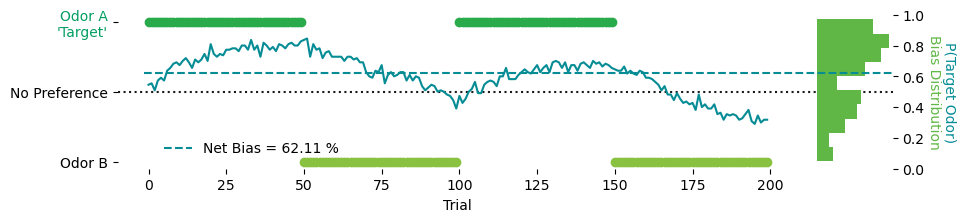

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


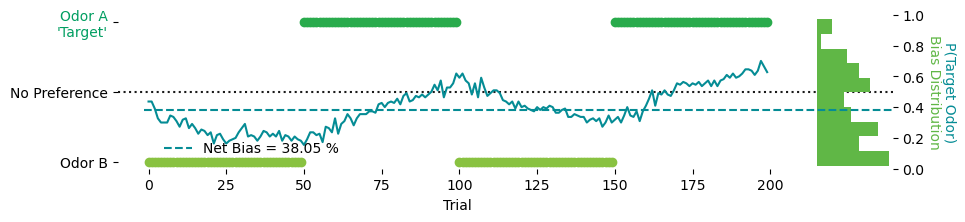

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


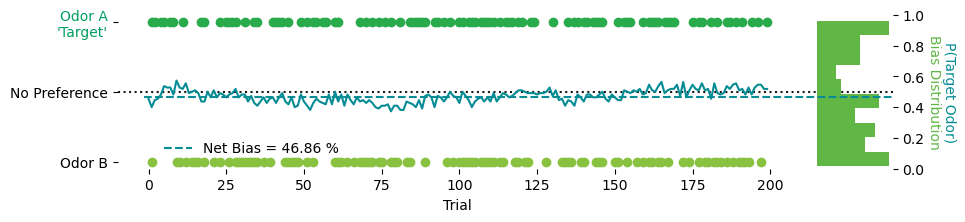

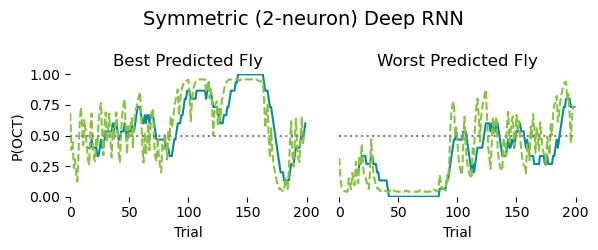

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


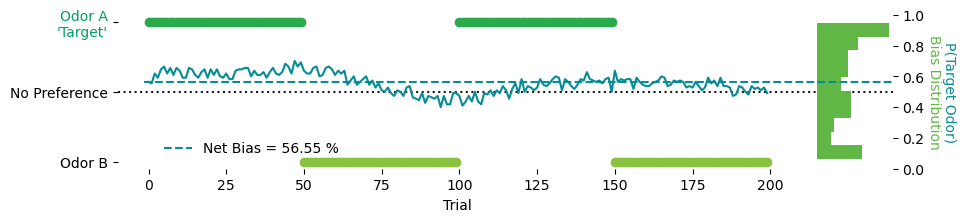

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


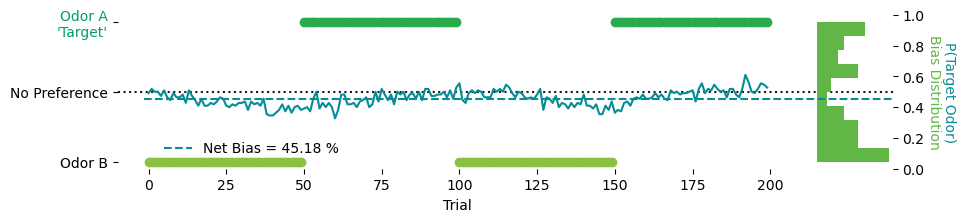

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


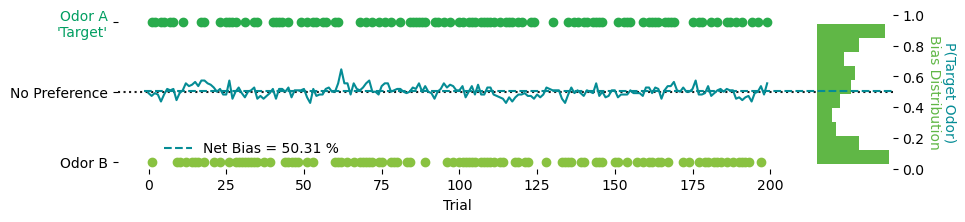

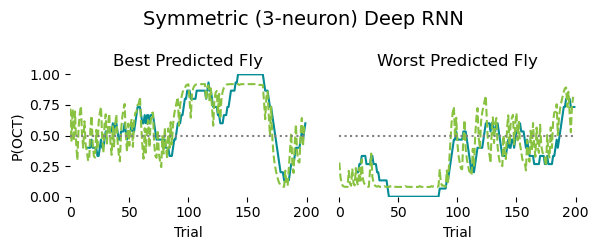

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


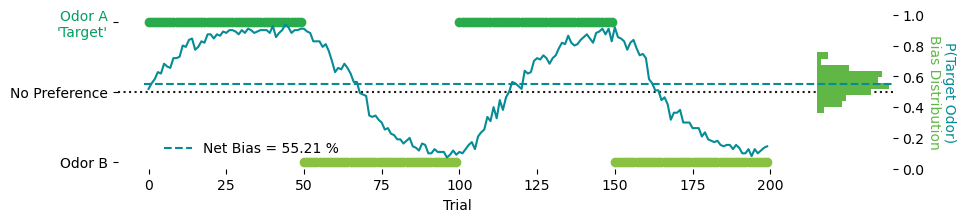

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


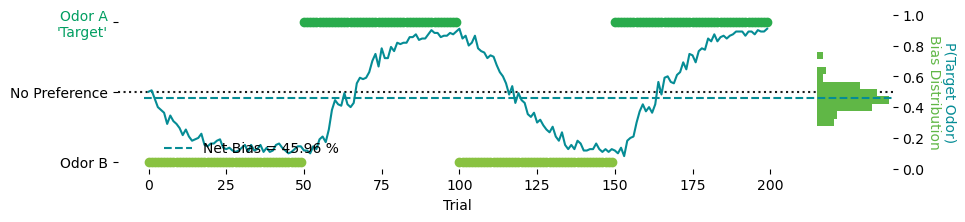

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


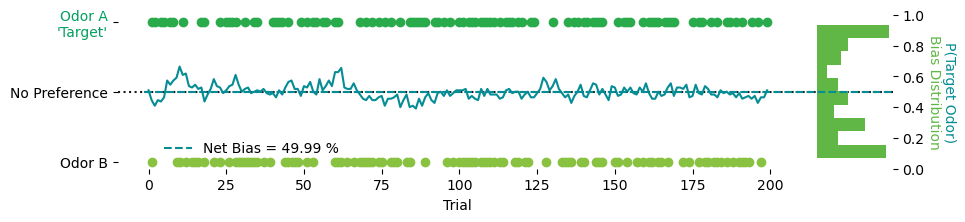

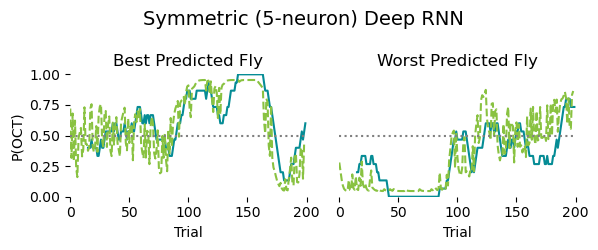

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


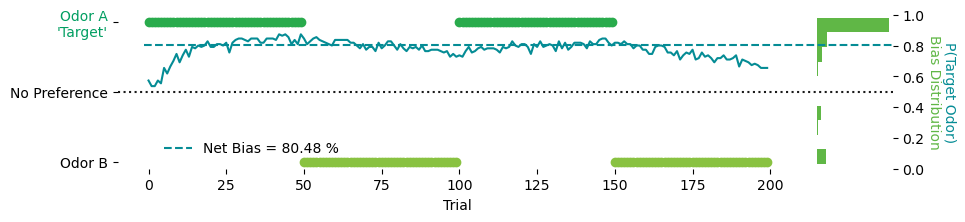

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


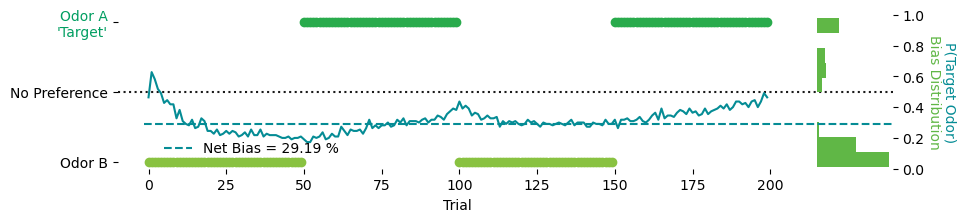

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


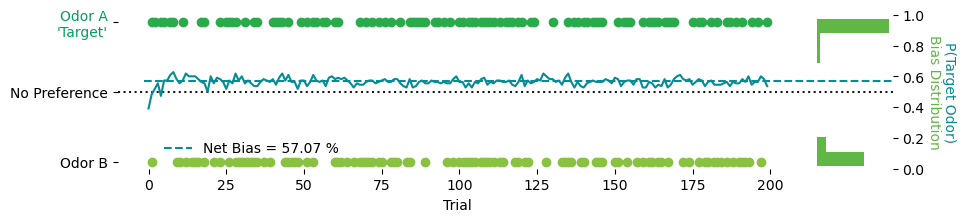

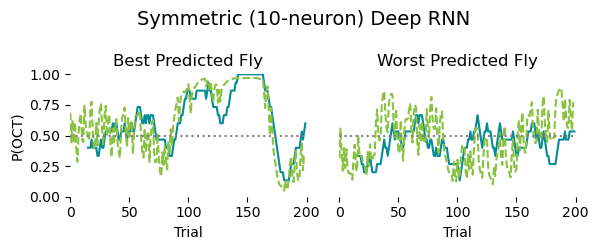

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


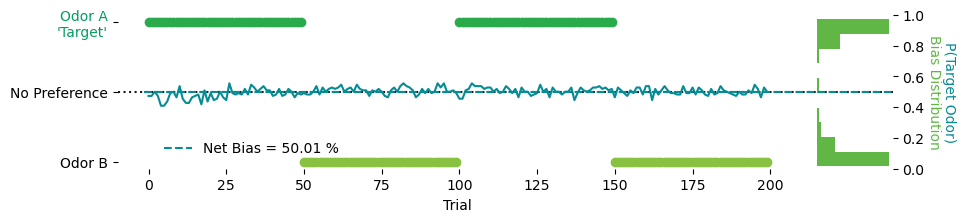

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


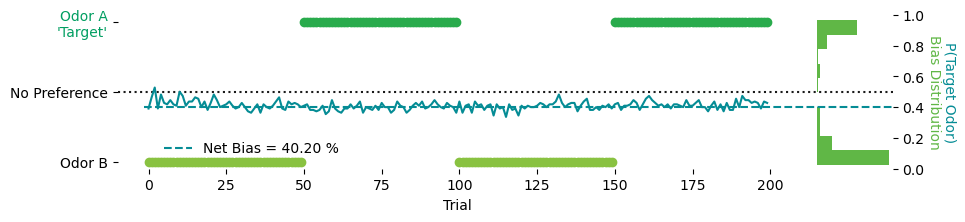

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


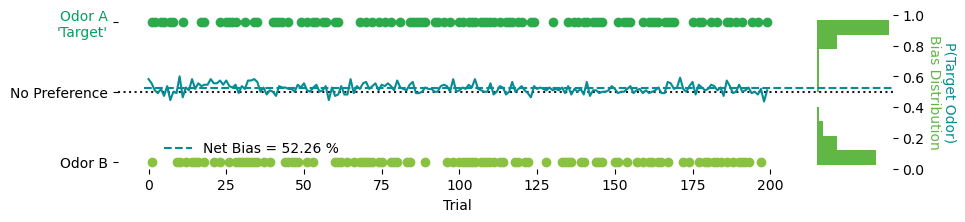

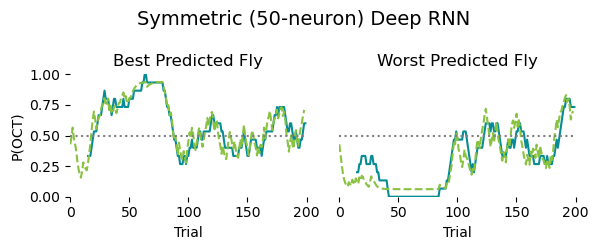

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


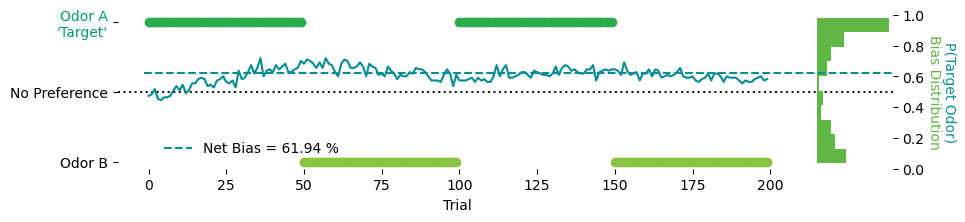

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


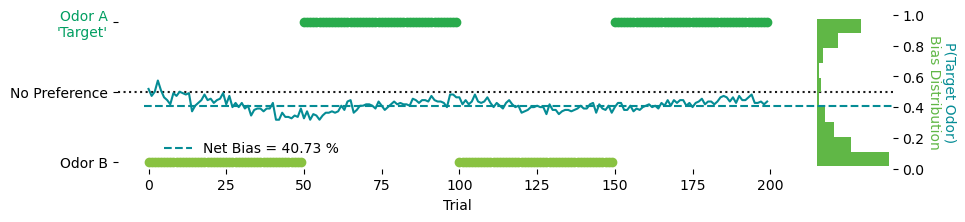

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


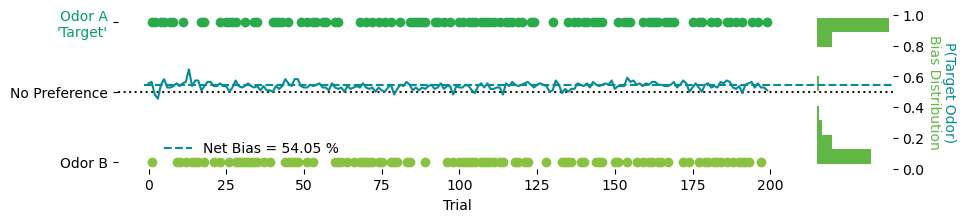

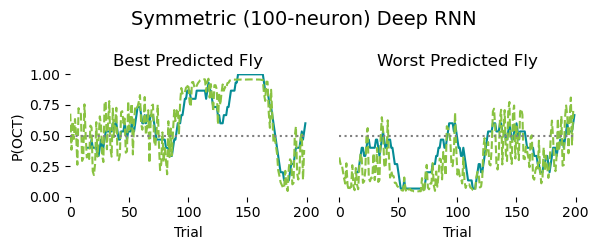

In [31]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

full_nmse = []
for model_size in [2,3,5,10,50,100]:
    toy_env = ymaze_static(experiment_size)
    params = {
        'reservoir_size':model_size,
        'num_layers':1,
        'symmetric_decision_network':True,
        'allow_negative_values':True,
        'omission_is_punishment':False,
        'encoder_size':None,
        'kind':"RNN",
        'policy_type':"softmax",
        'multi_agent': True,
        'n_agents': 100,
    }
    param_string=f"{params['reservoir_size']}_{params['num_layers']}_{int(params['symmetric_decision_network'])}{int(params['allow_negative_values'])}{int(params['omission_is_punishment'])}_{int(params['encoder_size']) if params['encoder_size'] is not None else 0}-{params['kind']}_{params['policy_type']}"

    if not os.path.exists(f"best_model_{param_string}.pt"):
        learner = GRNNLearner(toy_env,params)
        learner.fit(action_set,reward_set,n_replications=10)
        os.rename('best_model.pt',f'best_model_{param_string}.pt')

    env = ymaze_static(experiment_size,schedule=generate_random_schedule_with_blocks(experiment_size,np.tile([1.,0.],2),np.tile([0.,1.],2)))
    learner = GRNNLearner(env,params)
    learner.load_pre_trained_model(f'best_model_{param_string}.pt')
    learner.next_episode()
    draw_schedule(env.schedule,learner.action_history,save=True,filename=f'{param_string}_1.png')

    env = ymaze_static(experiment_size,schedule=generate_random_schedule_with_blocks(experiment_size,np.tile([0.,1.],2),np.tile([1.,0.],2)))
    learner = GRNNLearner(env,params)
    learner.load_pre_trained_model(f'best_model_{param_string}.pt')
    learner.next_episode()
    draw_schedule(env.schedule,learner.action_history,save=True,filename=f'{param_string}_2.png')

    env = ymaze_static(experiment_size,reward_fraction=0.5,random_seed=2020)
    learner = GRNNLearner(env,params)
    learner.load_pre_trained_model(f'best_model_{param_string}.pt')
    learner.next_episode()
    draw_schedule(env.schedule,learner.action_history,save=True,filename=f'{param_string}_3.png')

    model_name = f"{'Symmetric' if params['symmetric_decision_network'] else 'Asymmetric'} ({params['reservoir_size']}-neuron{' with '+params['encoder_size']+'encoders' if params['encoder_size'] is not None else ''}) Deep RNN"

    p_action = learner.get_action_probabilities_from_data(action_set,reward_set)

    history_size = 15

    best = np.inf
    best_ind = -1
    worst = -np.inf
    worst_ind = -1

    nmses = []
    for fly in range(p_action.shape[0]):
        obs_action_prob = np.convolve(action_set[fly],np.ones(history_size)/history_size,mode='full')[history_size:200]
        pred_action_prob = p_action[fly,history_size-1:]
        mse = np.mean((obs_action_prob-pred_action_prob)**2)
        nmse = mse/np.mean(obs_action_prob**2)
        if nmse < best:
            best = nmse
            best_ind = fly
        if nmse > worst:
            worst = nmse
            worst_ind = fly
        nmses.append(nmse)

    nmse_df = pd.DataFrame({'FlyID':range(p_action.shape[0]),'Model':[model_name]*p_action.shape[0],'Normalized Mean Squared Error':nmses})
    full_nmse.append(nmse_df)
    
    # Plot the best and worst fly
    obs_action_prob = np.convolve(action_set[best_ind],np.ones(history_size)/history_size,mode='full')[history_size:200]
    pred_action_prob = p_action[best_ind,:]
    plt.figure(figsize=(6,2.5))
    plt.subplot(121)
    plt.plot(np.arange(history_size,200),obs_action_prob,color=cmap(0.),label='Observed')
    plt.plot(pred_action_prob,'--',color=cmap(1.),label='Predicted')
    plt.hlines(0.5,0,200,color='gray',linestyle='dotted')
    # plt.legend(frameon=False,bbox_to_anchor=(1.05,1.05))
    plt.xlim([0,200])
    plt.ylim([0,1])
    plt.xlabel('Trial')
    plt.ylabel('P(OCT)')
    plt.box(False)
    plt.title('Best Predicted Fly')

    obs_action_prob = np.convolve(action_set[worst_ind],np.ones(history_size)/history_size,mode='full')[history_size:200]
    pred_action_prob = p_action[worst_ind,:]
    plt.subplot(122)
    plt.plot(np.arange(history_size,200),obs_action_prob,color=cmap(0.),label='Observed')
    plt.plot(pred_action_prob,'--',color=cmap(1.),label='Predicted')
    plt.hlines(0.5,0,200,color='gray',linestyle='dotted')
    plt.xlim([0,200])
    plt.ylim([0,1])
    plt.xlabel('Trial')
    plt.yticks([])
    plt.box(False)
    plt.title('Worst Predicted Fly')
    plt.suptitle(model_name,fontsize=14)
    plt.tight_layout()
    plt.savefig(f'best_worst_{param_string}.png',dpi=300,transparent=True)
    plt.show()


In [32]:
full_nmse = pd.concat(full_nmse)

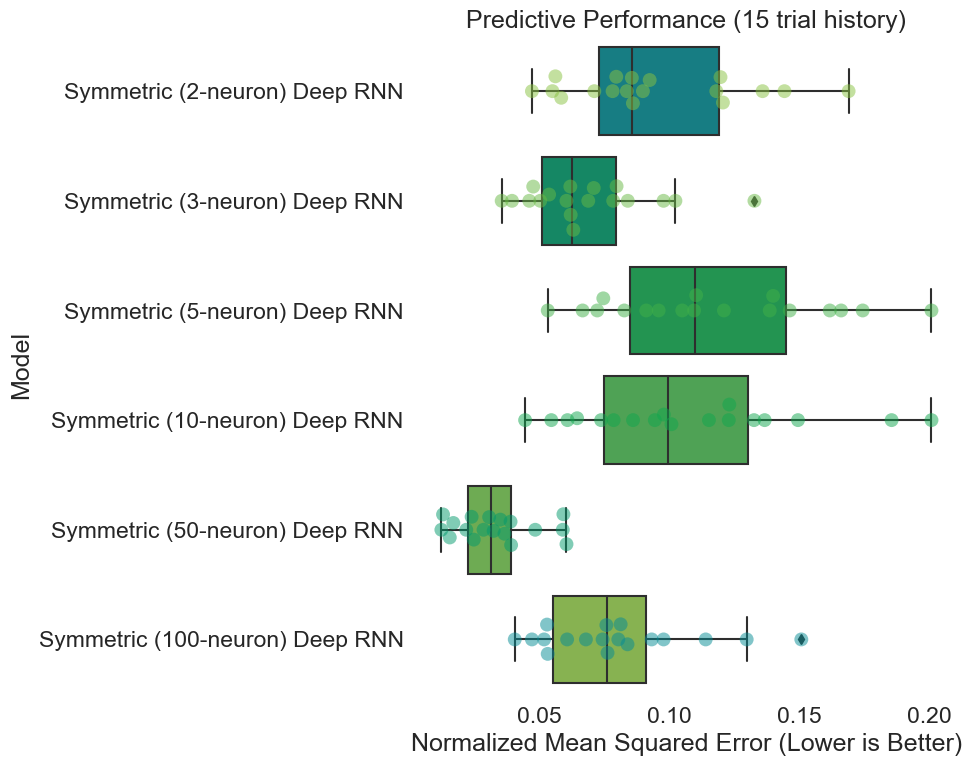

In [33]:
sns.set(style='ticks')
sns.set(font_scale=1.5)
plt.figure(figsize=(10,8))
sns.boxplot(y='Model',x='Normalized Mean Squared Error',data=full_nmse,palette=cmap(np.linspace(0,1,6)))
sns.swarmplot(y='Model',x='Normalized Mean Squared Error',data=full_nmse,palette=cmap(np.linspace(1,0,6)),size=10,alpha=0.5)
plt.box(False)
plt.xlabel('Normalized Mean Squared Error (Lower is Better)')
plt.title('Predictive Performance (15 trial history)')
plt.tight_layout()
plt.savefig('symmetric_rnn_predictive_performance_15.png',dpi=300,transparent=True)

## Asymmetric Q function

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


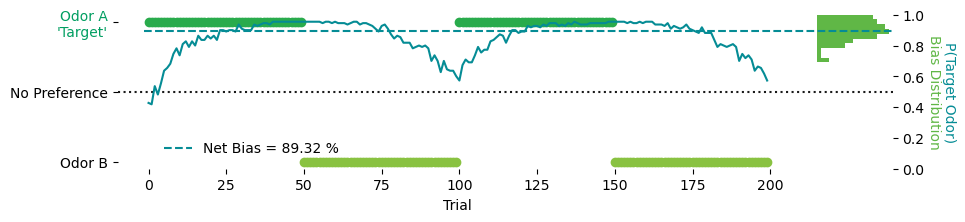

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


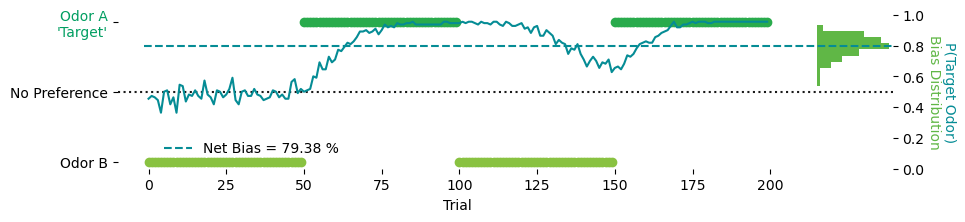

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


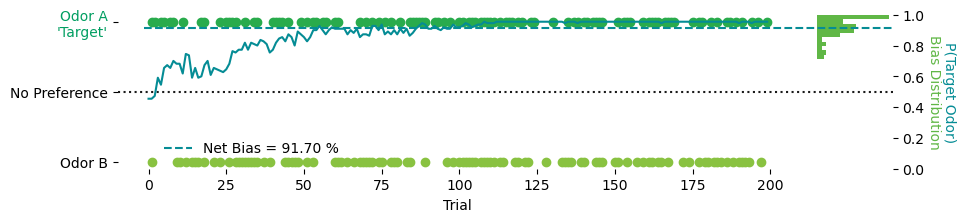

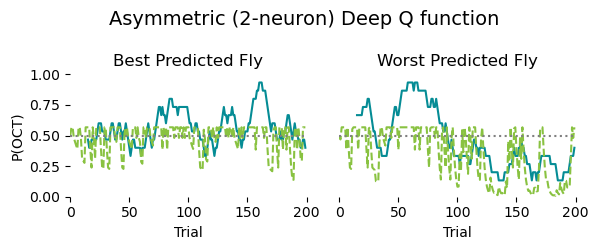

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


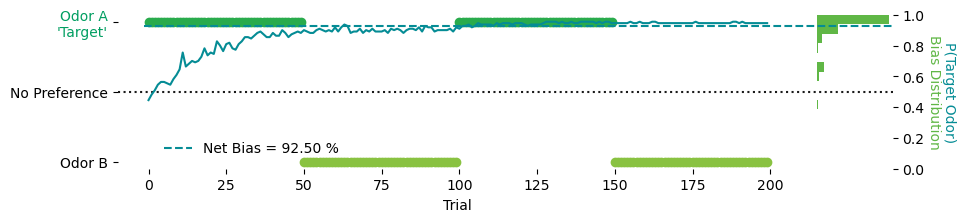

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


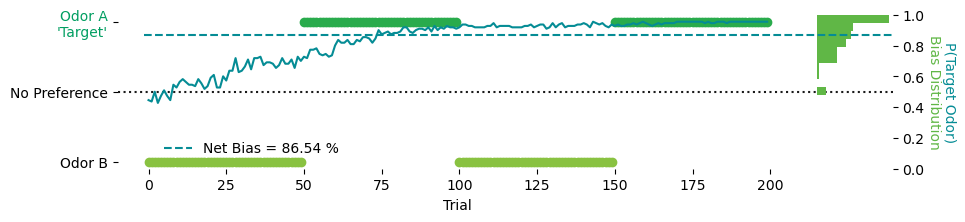

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


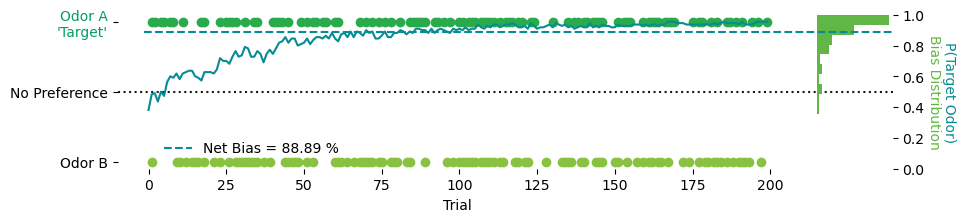

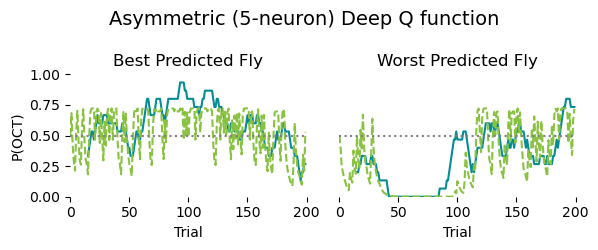

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


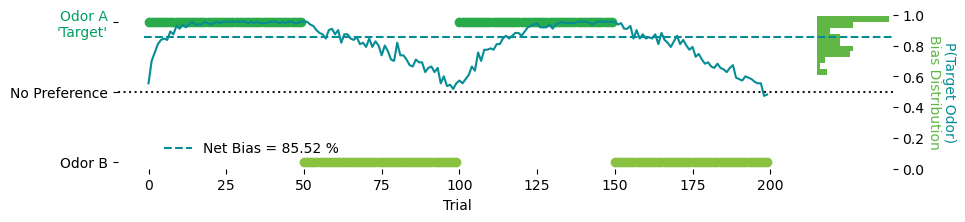

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


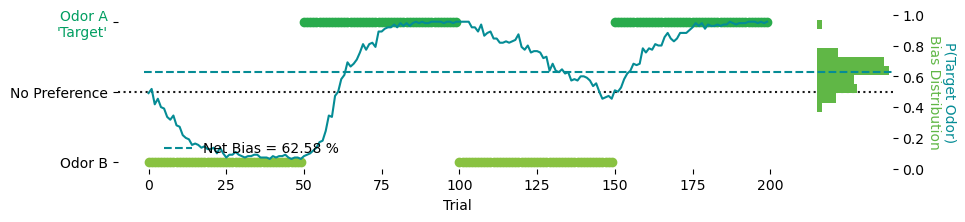

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


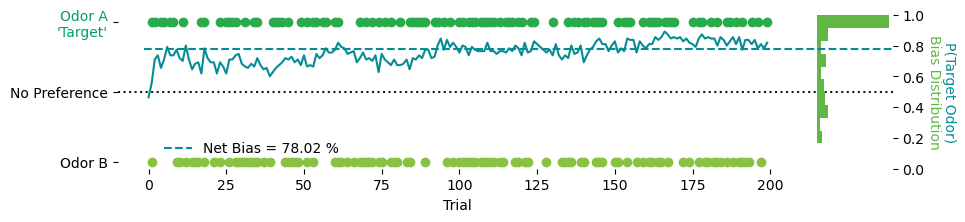

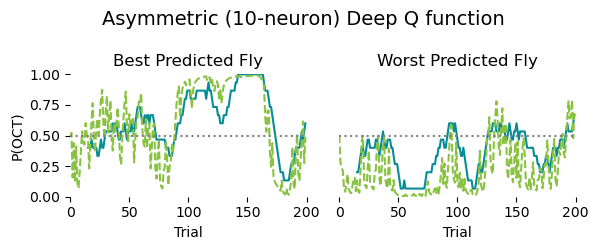

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


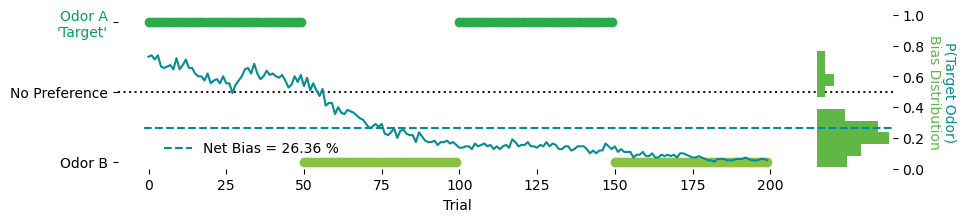

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


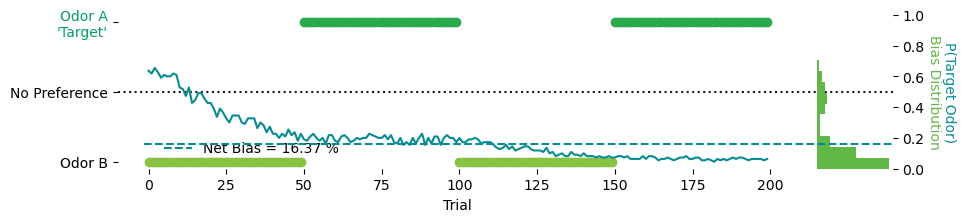

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


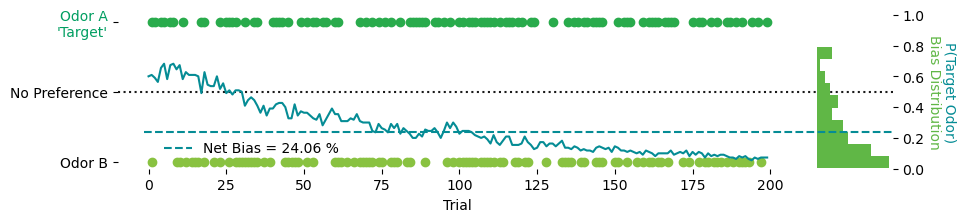

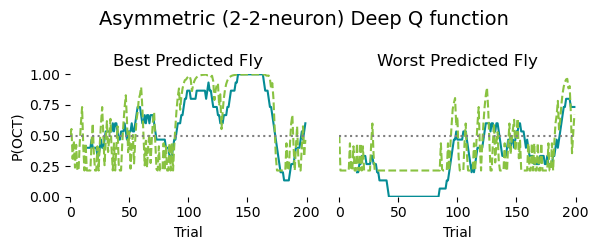

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


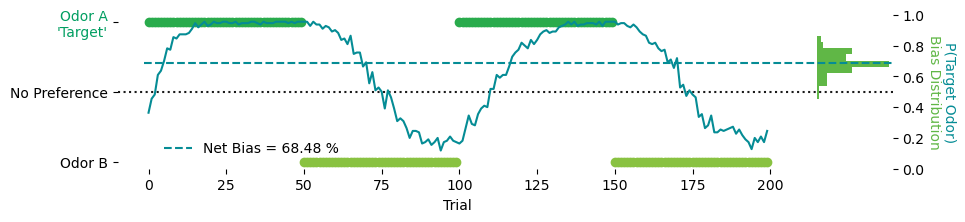

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


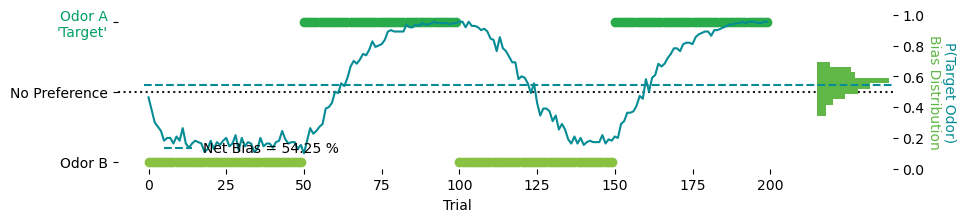

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


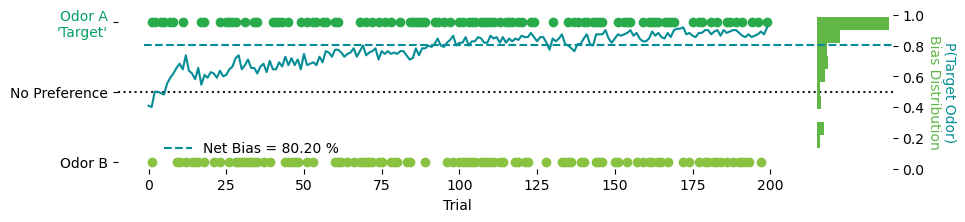

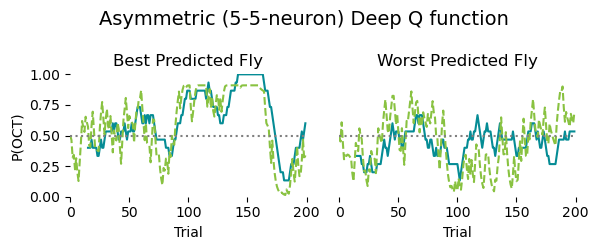

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


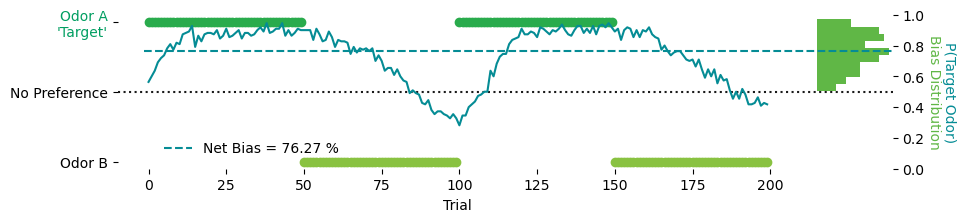

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


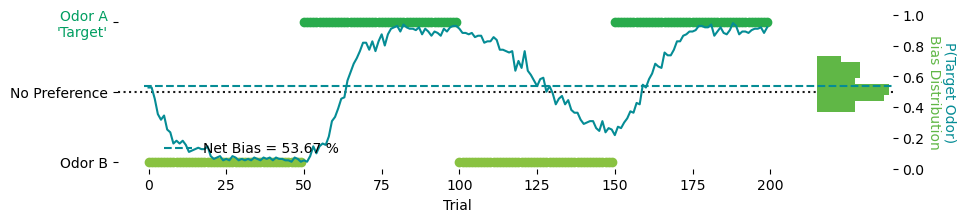

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


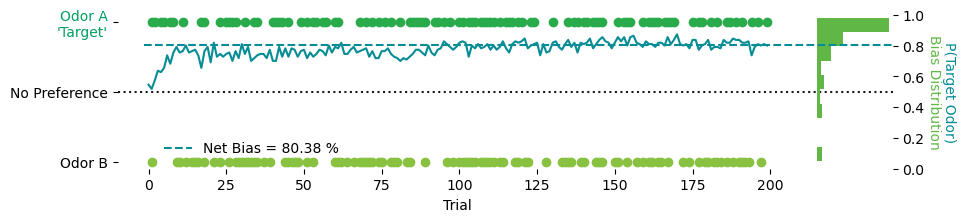

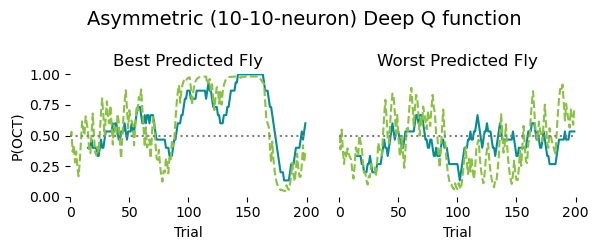

In [45]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

full_nmse = []
for model_size in [[2],[5],[10],[2,2],[5,5],[10,10]]:
    toy_env = ymaze_static(experiment_size)
    params = {
        'hidden_state_sizes':model_size,
        'symmetric_q_function':False,
        'allow_negative_q_values':True,
        'omission_is_punishment':False,
        'activation':'relu',
        'policy_type':"softmax",
        'multi_agent': True,
        'n_agents': 100,
    }

    param_string=f"{str(params['hidden_state_sizes']).replace('[','').replace(']','').replace(', ','-')}_{int(params['symmetric_q_function'])}{int(params['allow_negative_q_values'])}{int(params['omission_is_punishment'])}_{params['activation']}_{params['policy_type']}"

    if not os.path.exists(f"best_model_{param_string}.pt"):
        learner = GQLearner(toy_env,params)
        learner.fit(action_set,reward_set,n_replications=10)
        os.rename('best_model.pt',f'best_model_{param_string}.pt')

    env = ymaze_static(experiment_size,schedule=generate_random_schedule_with_blocks(experiment_size,np.tile([1.,0.],2),np.tile([0.,1.],2)))
    learner = GQLearner(env,params)
    learner.load_pre_trained_model(f'best_model_{param_string}.pt')
    learner.next_episode()
    draw_schedule(env.schedule,learner.action_history,save=True,filename=f'{param_string}_1.png')

    env = ymaze_static(experiment_size,schedule=generate_random_schedule_with_blocks(experiment_size,np.tile([0.,1.],2),np.tile([1.,0.],2)))
    learner = GQLearner(env,params)
    learner.load_pre_trained_model(f'best_model_{param_string}.pt')
    learner.next_episode()
    draw_schedule(env.schedule,learner.action_history,save=True,filename=f'{param_string}_2.png')

    env = ymaze_static(experiment_size,reward_fraction=0.5,random_seed=2020)
    learner = GQLearner(env,params)
    learner.load_pre_trained_model(f'best_model_{param_string}.pt')
    learner.next_episode()
    draw_schedule(env.schedule,learner.action_history,save=True,filename=f'{param_string}_3.png')

    model_name = f"{'Symmetric' if params['symmetric_q_function'] else 'Asymmetric'} ({str(params['hidden_state_sizes']).replace('[','').replace(']','').replace(', ','-')}-neuron) Deep Q function"

    p_action = learner.get_action_probabilities_from_data(action_set,reward_set)

    history_size = 15

    best = np.inf
    best_ind = -1
    worst = -np.inf
    worst_ind = -1

    nmses = []
    for fly in range(p_action.shape[0]):
        obs_action_prob = np.convolve(action_set[fly],np.ones(history_size)/history_size,mode='full')[history_size:200]
        pred_action_prob = p_action[fly,history_size:]
        mse = np.mean((obs_action_prob-pred_action_prob)**2)
        nmse = mse/np.mean(obs_action_prob**2)
        if nmse < best:
            best = nmse
            best_ind = fly
        if nmse > worst:
            worst = nmse
            worst_ind = fly
        nmses.append(nmse)

    nmse_df = pd.DataFrame({'FlyID':range(p_action.shape[0]),'Model':[model_name]*p_action.shape[0],'Normalized Mean Squared Error':nmses})
    full_nmse.append(nmse_df)
    
    # Plot the best and worst fly
    obs_action_prob = np.convolve(action_set[best_ind],np.ones(history_size)/history_size,mode='full')[history_size:200]
    pred_action_prob = p_action[best_ind,:]
    plt.figure(figsize=(6,2.5))
    plt.subplot(121)
    plt.plot(np.arange(history_size,200),obs_action_prob,color=cmap(0.),label='Observed')
    plt.plot(pred_action_prob,'--',color=cmap(1.),label='Predicted')
    plt.hlines(0.5,0,200,color='gray',linestyle='dotted')
    # plt.legend(frameon=False,bbox_to_anchor=(1.05,1.05))
    plt.xlim([0,200])
    plt.ylim([0,1])
    plt.xlabel('Trial')
    plt.ylabel('P(OCT)')
    plt.box(False)
    plt.title('Best Predicted Fly')

    obs_action_prob = np.convolve(action_set[worst_ind],np.ones(history_size)/history_size,mode='full')[history_size:200]
    pred_action_prob = p_action[worst_ind,:]
    plt.subplot(122)
    plt.plot(np.arange(history_size,200),obs_action_prob,color=cmap(0.),label='Observed')
    plt.plot(pred_action_prob,'--',color=cmap(1.),label='Predicted')
    plt.hlines(0.5,0,200,color='gray',linestyle='dotted')
    plt.xlim([0,200])
    plt.ylim([0,1])
    plt.xlabel('Trial')
    plt.yticks([])
    plt.box(False)
    plt.title('Worst Predicted Fly')
    plt.suptitle(model_name,fontsize=14)
    plt.tight_layout()
    plt.savefig(f'best_worst_{param_string}.png',dpi=300,transparent=True)
    plt.show()
    
full_nmse = pd.concat(full_nmse)

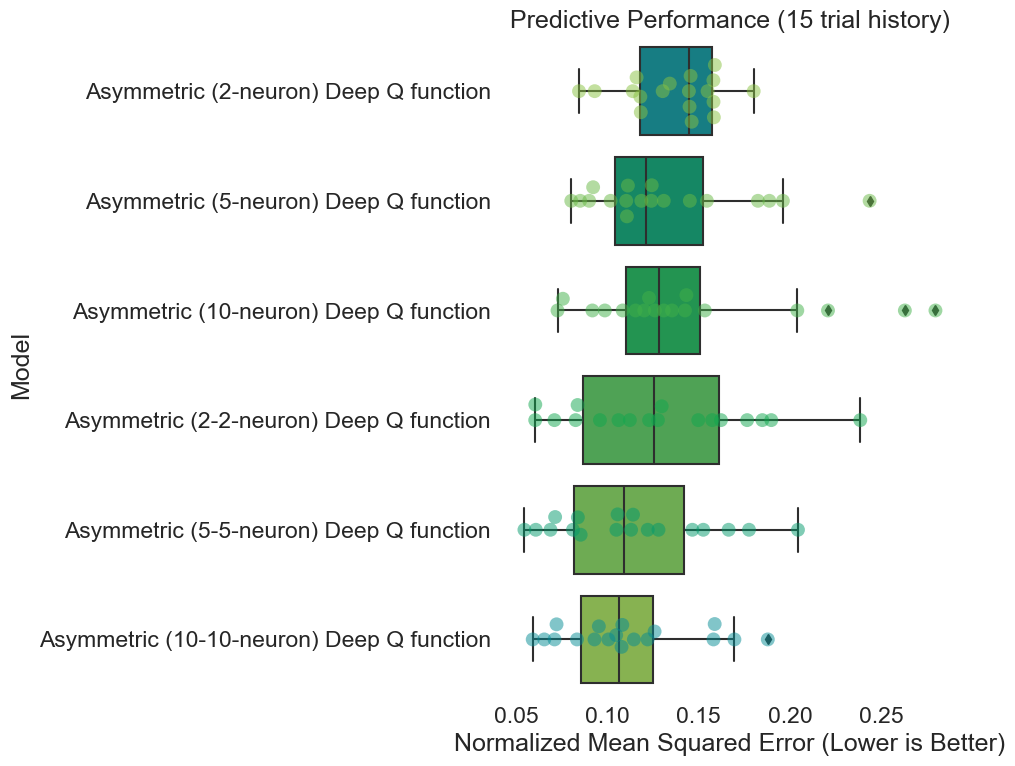

In [46]:
sns.set(style='ticks')
sns.set(font_scale=1.5)
plt.figure(figsize=(10,8))
sns.boxplot(y='Model',x='Normalized Mean Squared Error',data=full_nmse,palette=cmap(np.linspace(0,1,6)))
sns.swarmplot(y='Model',x='Normalized Mean Squared Error',data=full_nmse,palette=cmap(np.linspace(1,0,6)),size=10,alpha=0.5)
plt.box(False)
plt.xlabel('Normalized Mean Squared Error (Lower is Better)')
plt.title('Predictive Performance (15 trial history)')
plt.tight_layout()
plt.savefig('asymmetric_q_predictive_performance_15.png',dpi=300,transparent=True)

# Symmetric Q function

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


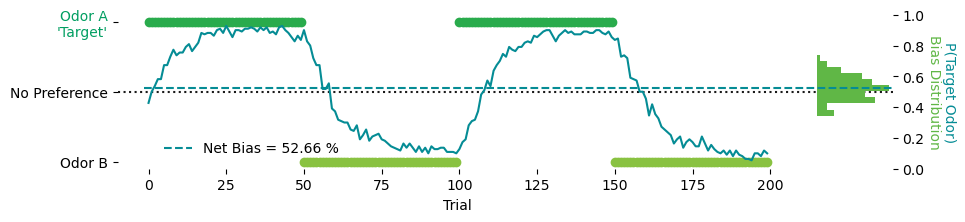

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


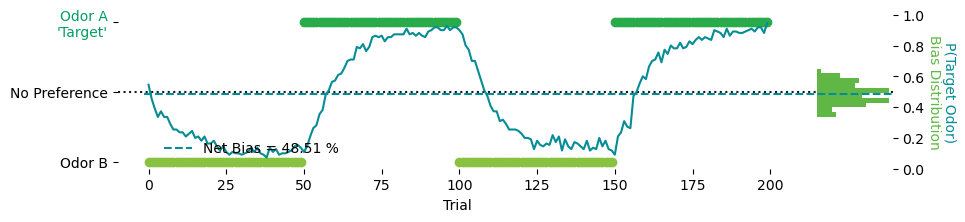

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


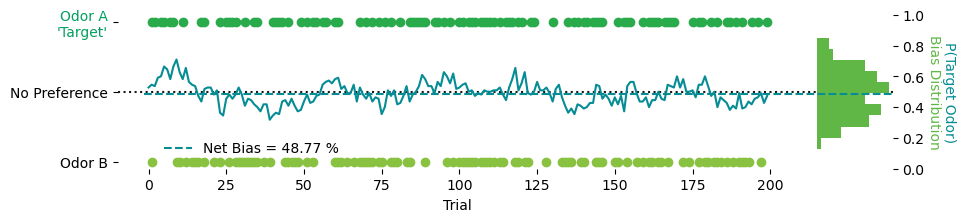

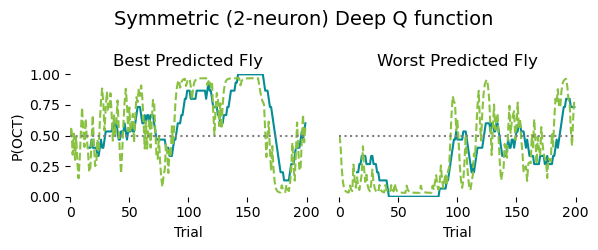

Epoch 0: 	Training Loss: 0.7057	Validation Loss: 0.7042
Epoch 500: 	Training Loss: 0.6654	Validation Loss: 0.6659
Epoch   770: reducing learning rate of group 0 to 2.5000e-04.
Epoch   777: reducing learning rate of group 0 to 1.2500e-04.
Epoch   783: reducing learning rate of group 0 to 6.2500e-05.
Epoch   789: reducing learning rate of group 0 to 3.1250e-05.
Epoch   795: reducing learning rate of group 0 to 1.5625e-05.
Epoch   801: reducing learning rate of group 0 to 7.8125e-06.
Epoch   807: reducing learning rate of group 0 to 3.9063e-06.
Epoch   813: reducing learning rate of group 0 to 1.9531e-06.
Epoch   819: reducing learning rate of group 0 to 9.7656e-07.
Epoch   825: reducing learning rate of group 0 to 4.8828e-07.
Epoch   831: reducing learning rate of group 0 to 2.4414e-07.
Epoch   837: reducing learning rate of group 0 to 1.2207e-07.
Epoch   843: reducing learning rate of group 0 to 6.1035e-08.
Epoch   849: reducing learning rate of group 0 to 3.0518e-08.
Epoch   855: reduc

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


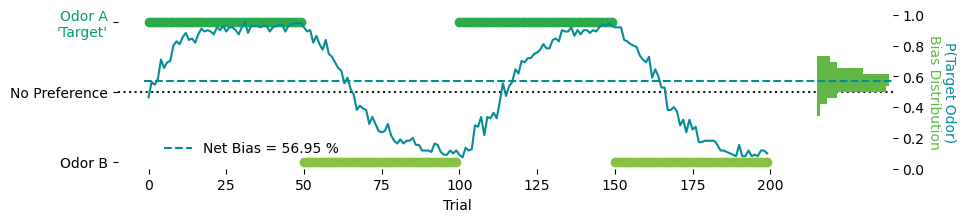

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


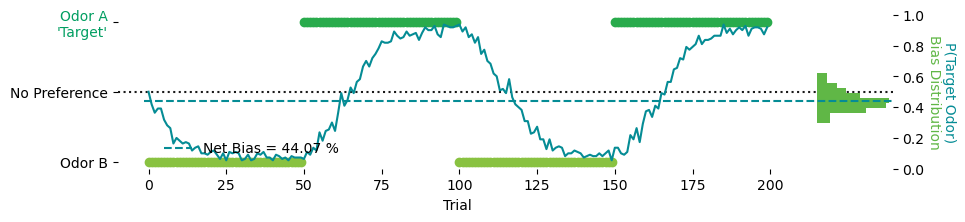

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


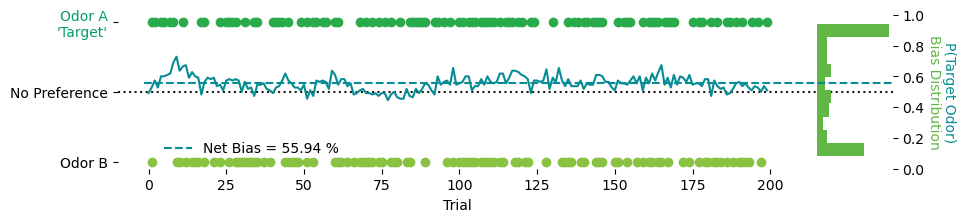

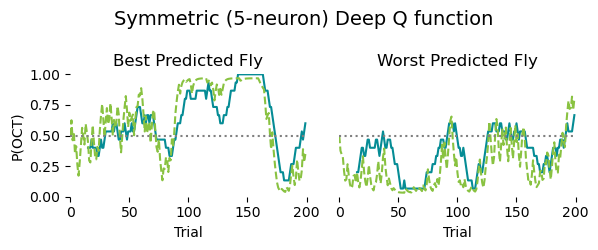

Epoch 0: 	Training Loss: 0.6880	Validation Loss: 0.6860
Epoch 500: 	Training Loss: 0.6469	Validation Loss: 0.6225
Epoch   762: reducing learning rate of group 0 to 2.5000e-04.
Epoch   797: reducing learning rate of group 0 to 1.2500e-04.
Epoch   803: reducing learning rate of group 0 to 6.2500e-05.
Epoch   815: reducing learning rate of group 0 to 3.1250e-05.
Epoch   821: reducing learning rate of group 0 to 1.5625e-05.
Epoch   827: reducing learning rate of group 0 to 7.8125e-06.
Epoch   833: reducing learning rate of group 0 to 3.9063e-06.
Epoch   839: reducing learning rate of group 0 to 1.9531e-06.
Epoch   845: reducing learning rate of group 0 to 9.7656e-07.
Epoch   851: reducing learning rate of group 0 to 4.8828e-07.
Epoch   857: reducing learning rate of group 0 to 2.4414e-07.
Epoch   863: reducing learning rate of group 0 to 1.2207e-07.
Epoch   869: reducing learning rate of group 0 to 6.1035e-08.
Epoch   875: reducing learning rate of group 0 to 3.0518e-08.
Epoch   881: reduc

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


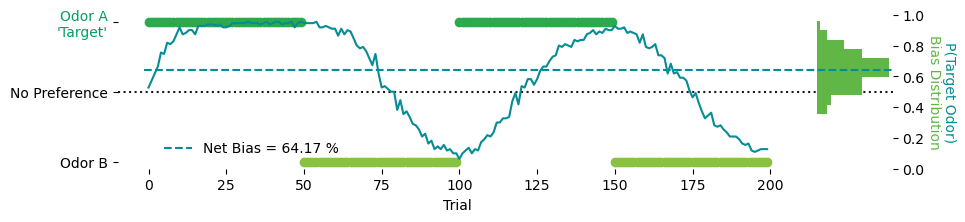

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


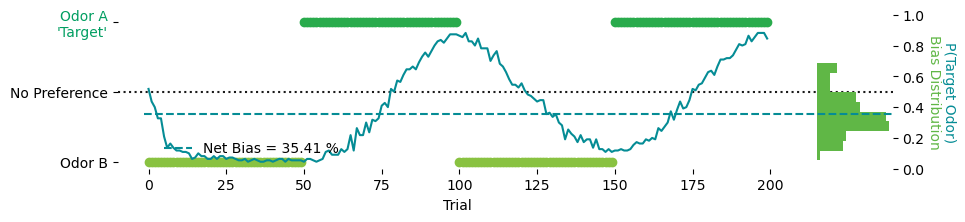

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


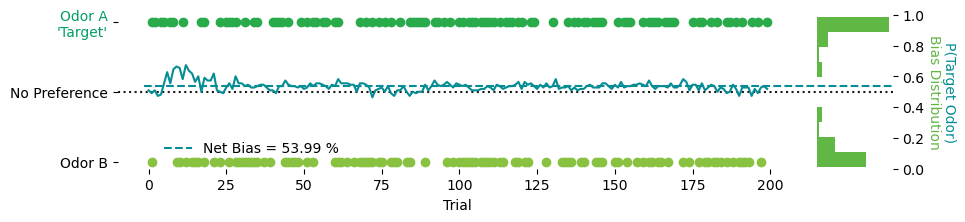

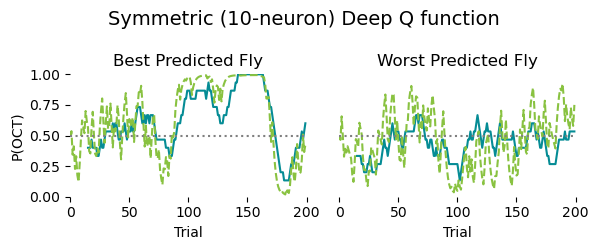

Epoch 0: 	Training Loss: 0.7072	Validation Loss: 0.7097
Epoch 500: 	Training Loss: 0.6735	Validation Loss: 0.6651
Epoch 1000: 	Training Loss: 0.6627	Validation Loss: 0.6455
Epoch  1227: reducing learning rate of group 0 to 2.5000e-04.
Epoch  1233: reducing learning rate of group 0 to 1.2500e-04.
Epoch  1239: reducing learning rate of group 0 to 6.2500e-05.
Epoch  1245: reducing learning rate of group 0 to 3.1250e-05.
Epoch  1251: reducing learning rate of group 0 to 1.5625e-05.
Epoch  1257: reducing learning rate of group 0 to 7.8125e-06.
Epoch  1263: reducing learning rate of group 0 to 3.9063e-06.
Epoch  1269: reducing learning rate of group 0 to 1.9531e-06.
Early stopping at epoch 1270
Epoch 0: 	Training Loss: 0.6554	Validation Loss: 0.6567
Epoch 500: 	Training Loss: 0.6398	Validation Loss: 0.6366
Epoch   568: reducing learning rate of group 0 to 2.5000e-04.
Epoch   575: reducing learning rate of group 0 to 1.2500e-04.
Epoch   583: reducing learning rate of group 0 to 6.2500e-05.
Ep

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


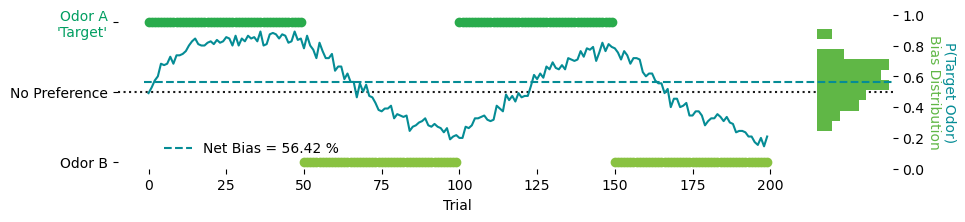

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


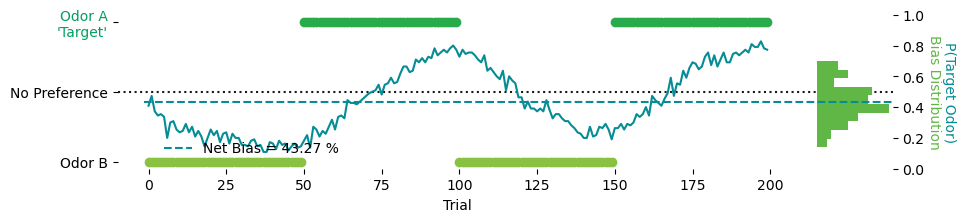

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


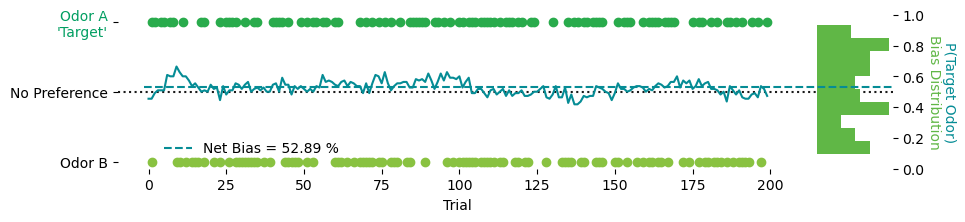

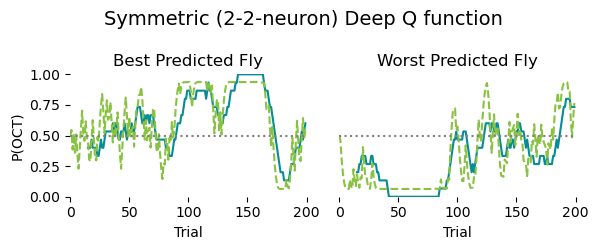

Epoch 0: 	Training Loss: 0.6928	Validation Loss: 0.6927
Epoch 500: 	Training Loss: 0.6439	Validation Loss: 0.6516
Epoch   774: reducing learning rate of group 0 to 2.5000e-04.
Epoch   783: reducing learning rate of group 0 to 1.2500e-04.
Epoch   789: reducing learning rate of group 0 to 6.2500e-05.
Epoch   795: reducing learning rate of group 0 to 3.1250e-05.
Epoch   801: reducing learning rate of group 0 to 1.5625e-05.
Epoch   807: reducing learning rate of group 0 to 7.8125e-06.
Epoch   813: reducing learning rate of group 0 to 3.9063e-06.
Epoch   819: reducing learning rate of group 0 to 1.9531e-06.
Epoch   825: reducing learning rate of group 0 to 9.7656e-07.
Epoch   831: reducing learning rate of group 0 to 4.8828e-07.
Epoch   837: reducing learning rate of group 0 to 2.4414e-07.
Epoch   843: reducing learning rate of group 0 to 1.2207e-07.
Epoch   849: reducing learning rate of group 0 to 6.1035e-08.
Epoch   855: reducing learning rate of group 0 to 3.0518e-08.
Epoch   861: reduc

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


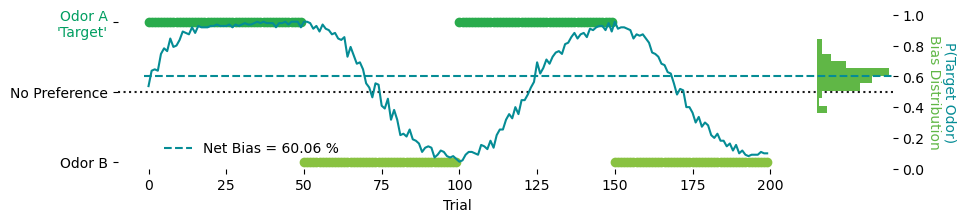

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


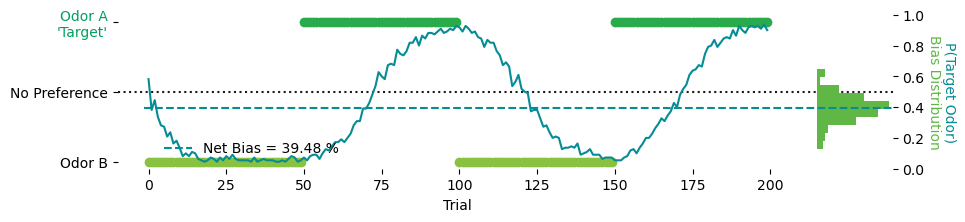

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


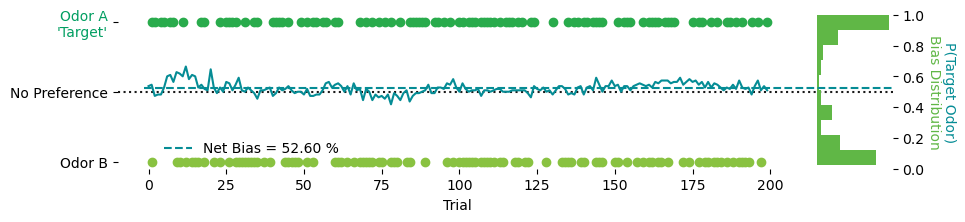

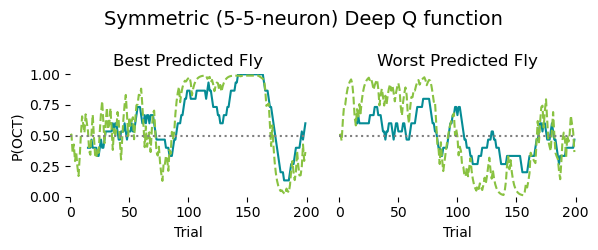

Epoch 0: 	Training Loss: 0.6889	Validation Loss: 0.6892
Epoch   391: reducing learning rate of group 0 to 2.5000e-04.
Epoch   397: reducing learning rate of group 0 to 1.2500e-04.
Epoch   404: reducing learning rate of group 0 to 6.2500e-05.
Epoch   410: reducing learning rate of group 0 to 3.1250e-05.
Epoch   416: reducing learning rate of group 0 to 1.5625e-05.
Epoch   422: reducing learning rate of group 0 to 7.8125e-06.
Epoch   428: reducing learning rate of group 0 to 3.9063e-06.
Epoch   434: reducing learning rate of group 0 to 1.9531e-06.
Epoch   440: reducing learning rate of group 0 to 9.7656e-07.
Epoch   446: reducing learning rate of group 0 to 4.8828e-07.
Epoch   452: reducing learning rate of group 0 to 2.4414e-07.
Epoch   458: reducing learning rate of group 0 to 1.2207e-07.
Epoch   464: reducing learning rate of group 0 to 6.1035e-08.
Epoch   470: reducing learning rate of group 0 to 3.0518e-08.
Epoch   476: reducing learning rate of group 0 to 1.5259e-08.
Early stopping

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


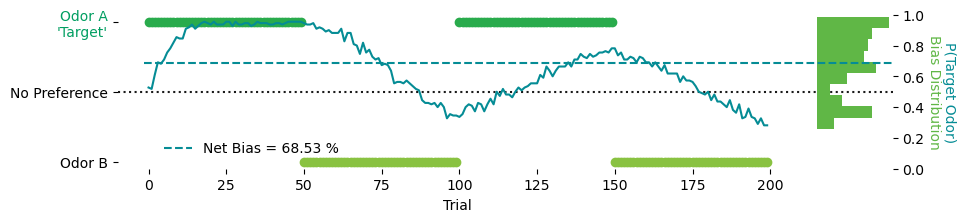

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


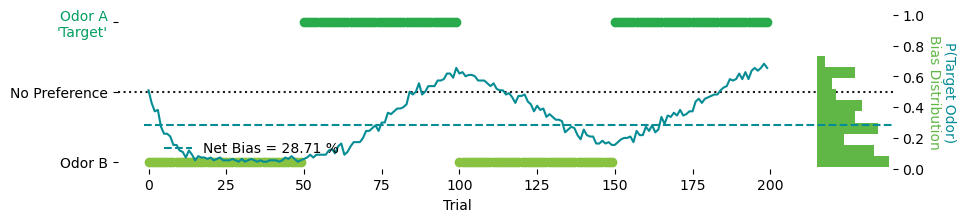

c:\Rishika\Projects\FlYMazeRL\utils\visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


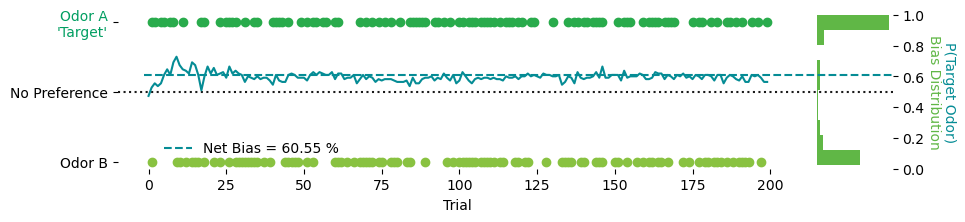

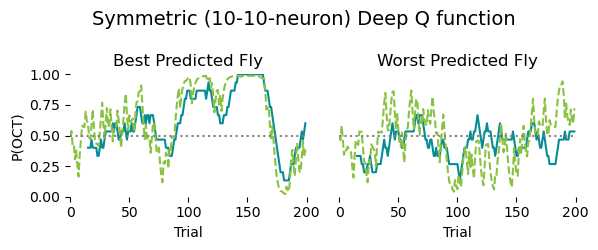

In [47]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

full_nmse = []
for model_size in [[2],[5],[10],[2,2],[5,5],[10,10]]:
    toy_env = ymaze_static(experiment_size)
    params = {
        'hidden_state_sizes':model_size,
        'symmetric_q_function':True,
        'allow_negative_q_values':True,
        'omission_is_punishment':False,
        'activation':'relu',
        'policy_type':"softmax",
        'multi_agent': True,
        'n_agents': 100,
    }

    param_string=f"{str(params['hidden_state_sizes']).replace('[','').replace(']','').replace(', ','-')}_{int(params['symmetric_q_function'])}{int(params['allow_negative_q_values'])}{int(params['omission_is_punishment'])}_{params['activation']}_{params['policy_type']}"

    if not os.path.exists(f"best_model_{param_string}.pt"):
        learner = GQLearner(toy_env,params)
        learner.fit(action_set,reward_set,n_replications=10)
        os.rename('best_model.pt',f'best_model_{param_string}.pt')

    env = ymaze_static(experiment_size,schedule=generate_random_schedule_with_blocks(experiment_size,np.tile([1.,0.],2),np.tile([0.,1.],2)))
    learner = GQLearner(env,params)
    learner.load_pre_trained_model(f'best_model_{param_string}.pt')
    learner.next_episode()
    draw_schedule(env.schedule,learner.action_history,save=True,filename=f'{param_string}_1.png')

    env = ymaze_static(experiment_size,schedule=generate_random_schedule_with_blocks(experiment_size,np.tile([0.,1.],2),np.tile([1.,0.],2)))
    learner = GQLearner(env,params)
    learner.load_pre_trained_model(f'best_model_{param_string}.pt')
    learner.next_episode()
    draw_schedule(env.schedule,learner.action_history,save=True,filename=f'{param_string}_2.png')

    env = ymaze_static(experiment_size,reward_fraction=0.5,random_seed=2020)
    learner = GQLearner(env,params)
    learner.load_pre_trained_model(f'best_model_{param_string}.pt')
    learner.next_episode()
    draw_schedule(env.schedule,learner.action_history,save=True,filename=f'{param_string}_3.png')

    model_name = f"{'Symmetric' if params['symmetric_q_function'] else 'Asymmetric'} ({str(params['hidden_state_sizes']).replace('[','').replace(']','').replace(', ','-')}-neuron) Deep Q function"

    p_action = learner.get_action_probabilities_from_data(action_set,reward_set)

    history_size = 15

    best = np.inf
    best_ind = -1
    worst = -np.inf
    worst_ind = -1

    nmses = []
    for fly in range(p_action.shape[0]):
        obs_action_prob = np.convolve(action_set[fly],np.ones(history_size)/history_size,mode='full')[history_size:200]
        pred_action_prob = p_action[fly,history_size:]
        mse = np.mean((obs_action_prob-pred_action_prob)**2)
        nmse = mse/np.mean(obs_action_prob**2)
        if nmse < best:
            best = nmse
            best_ind = fly
        if nmse > worst:
            worst = nmse
            worst_ind = fly
        nmses.append(nmse)

    nmse_df = pd.DataFrame({'FlyID':range(p_action.shape[0]),'Model':[model_name]*p_action.shape[0],'Normalized Mean Squared Error':nmses})
    full_nmse.append(nmse_df)
    
    # Plot the best and worst fly
    obs_action_prob = np.convolve(action_set[best_ind],np.ones(history_size)/history_size,mode='full')[history_size:200]
    pred_action_prob = p_action[best_ind,:]
    plt.figure(figsize=(6,2.5))
    plt.subplot(121)
    plt.plot(np.arange(history_size,200),obs_action_prob,color=cmap(0.),label='Observed')
    plt.plot(pred_action_prob,'--',color=cmap(1.),label='Predicted')
    plt.hlines(0.5,0,200,color='gray',linestyle='dotted')
    # plt.legend(frameon=False,bbox_to_anchor=(1.05,1.05))
    plt.xlim([0,200])
    plt.ylim([0,1])
    plt.xlabel('Trial')
    plt.ylabel('P(OCT)')
    plt.box(False)
    plt.title('Best Predicted Fly')

    obs_action_prob = np.convolve(action_set[worst_ind],np.ones(history_size)/history_size,mode='full')[history_size:200]
    pred_action_prob = p_action[worst_ind,:]
    plt.subplot(122)
    plt.plot(np.arange(history_size,200),obs_action_prob,color=cmap(0.),label='Observed')
    plt.plot(pred_action_prob,'--',color=cmap(1.),label='Predicted')
    plt.hlines(0.5,0,200,color='gray',linestyle='dotted')
    plt.xlim([0,200])
    plt.ylim([0,1])
    plt.xlabel('Trial')
    plt.yticks([])
    plt.box(False)
    plt.title('Worst Predicted Fly')
    plt.suptitle(model_name,fontsize=14)
    plt.tight_layout()
    plt.savefig(f'best_worst_{param_string}.png',dpi=300,transparent=True)
    plt.show()
    
full_nmse = pd.concat(full_nmse)

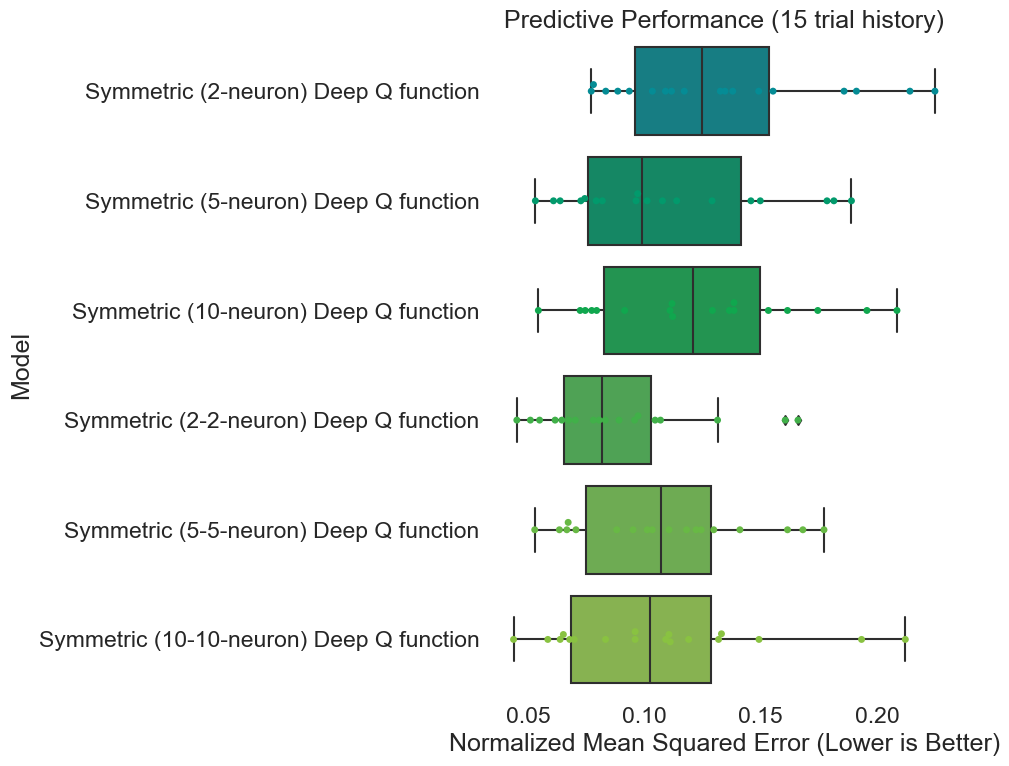

In [49]:
sns.set(style='ticks')
sns.set(font_scale=1.5)
plt.figure(figsize=(10,8))
sns.boxplot(y='Model',x='Normalized Mean Squared Error',data=full_nmse,palette=cmap(np.linspace(0,1,6)))
sns.swarmplot(y='Model',x='Normalized Mean Squared Error',data=full_nmse,palette=cmap(np.linspace(0,1,6)))
plt.box(False)
plt.xlabel('Normalized Mean Squared Error (Lower is Better)')
plt.title('Predictive Performance (15 trial history)')
plt.tight_layout()
plt.savefig('symmetric_q_predictive_performance_15.png',dpi=300,transparent=True)

In [1]:


model_name = "Asymmetric (10-reservoir) Deep RNN"

p_action = learner.get_action_probabilities_from_data(action_set,reward_set)

history_size = 15

best = np.inf
best_ind = -1
worst = -np.inf
worst_ind = -1

nmses = []
for fly in range(p_action.shape[0]):
    obs_action_prob = np.convolve(action_set[fly],np.ones(history_size)/history_size,mode='full')[history_size:200]
    pred_action_prob = p_action[fly,history_size-1:]
    mse = np.mean((obs_action_prob-pred_action_prob)**2)
    nmse = mse/np.mean(obs_action_prob**2)
    if nmse < best:
        best = nmse
        best_ind = fly
    if nmse > worst:
        worst = nmse
        worst_ind = fly
    nmses.append(nmse)

nmse_df = pd.DataFrame({'FlyID':range(p_action.shape[0]),'Model':[model_name]*p_action.shape[0],'Normalized Mean Squared Error':nmses})

# Plot the best and worst fly
obs_action_prob = np.convolve(action_set[best_ind],np.ones(history_size)/history_size,mode='full')[history_size:200]
pred_action_prob = p_action[best_ind,:]
plt.figure(figsize=(6,2.5))
plt.subplot(121)
plt.plot(np.arange(history_size,200),obs_action_prob,color=cmap(0.),label='Observed')
plt.plot(pred_action_prob,'--',color=cmap(1.),label='Predicted')
plt.hlines(0.5,0,200,color='gray',linestyle='dotted')
# plt.legend(frameon=False,bbox_to_anchor=(1.05,1.05))
plt.xlim([0,200])
plt.ylim([0,1])
plt.xlabel('Trial')
plt.ylabel('P(OCT)')
plt.box(False)
plt.title('Best Predicted Fly')

obs_action_prob = np.convolve(action_set[worst_ind],np.ones(history_size)/history_size,mode='full')[history_size:200]
pred_action_prob = p_action[worst_ind,:]
plt.subplot(122)
plt.plot(np.arange(history_size,200),obs_action_prob,color=cmap(0.),label='Observed')
plt.plot(pred_action_prob,'--',color=cmap(1.),label='Predicted')
plt.hlines(0.5,0,200,color='gray',linestyle='dotted')
plt.xlim([0,200])
plt.ylim([0,1])
plt.xlabel('Trial')
plt.yticks([])
plt.box(False)
plt.title('Worst Predicted Fly')
plt.suptitle(model_name,fontsize=14)
plt.tight_layout()
plt.savefig(f'best_worst_{model_name}.png',dpi=300,transparent=True)
plt.show()

NameError: ignored

In [91]:
nmse_df['Normalized Mean Squared Error'].median()

0.13429336279015514

In [ ]:

learner = GQLearner(env,params)
learner.fit(action_set,reward_set,n_replications=10)
# learner.load_pre_trained_model("best_model.pt")

In [51]:
learner.next_episode()
draw_schedule(env.schedule,learner.action_history)

RuntimeError: ignored

/content/FlYMazeRL/utils/visualization.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


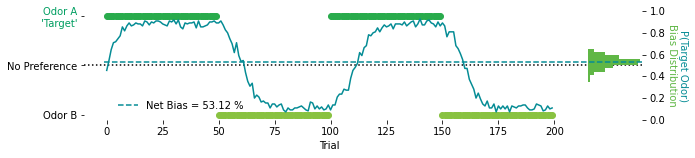

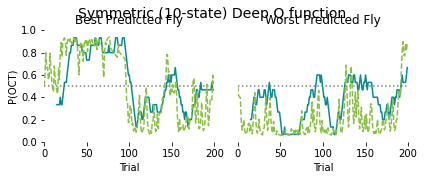

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.colors as mcolors

def hex_to_rgb(hex_code):
    hex_code = hex_code.strip("#");lv = len(hex_code);rgb = tuple(int(hex_code[i : i + lv // 3], 16) for i in range(0, lv, lv // 3));return rgb
def rgb_to_dec(rgb):
    return [v / 256 for v in rgb]
def get_continuous_cmap(hex_list, float_list=None):
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list: pass
    else: float_list = list(np.linspace(0, 1, len(rgb_list)))
    cdict = dict()
    for num, col in enumerate(["red", "green", "blue"]): col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]; cdict[col] = col_list
    return mcolors.LinearSegmentedColormap("my_cmp", segmentdata=cdict, N=256)

cmap = get_continuous_cmap(["058d96", "00a450", "52b448", "8ac341"])

model_name = "Symmetric (10-state) Deep Q function"

p_action = learner.get_action_probabilities_from_data(action_set,reward_set)

history_size = 15

best = np.inf
best_ind = -1
worst = -np.inf
worst_ind = -1

nmses = []
for fly in range(p_action.shape[0]):
    obs_action_prob = np.convolve(action_set[fly],np.ones(history_size)/history_size,mode='full')[history_size:200]
    pred_action_prob = p_action[fly,history_size:]
    mse = np.mean((obs_action_prob-pred_action_prob)**2)
    nmse = mse/np.mean(obs_action_prob**2)
    if nmse < best:
        best = nmse
        best_ind = fly
    if nmse > worst:
        worst = nmse
        worst_ind = fly
    nmses.append(nmse)

nmse_df = pd.DataFrame({'FlyID':range(p_action.shape[0]),'Model':[model_name]*p_action.shape[0],'Normalized Mean Squared Error':nmses})

# Plot the best and worst fly
obs_action_prob = np.convolve(action_set[best_ind],np.ones(history_size)/history_size,mode='full')[history_size:200]
pred_action_prob = p_action[best_ind,:]
plt.figure(figsize=(6,2.5))
plt.subplot(121)
plt.plot(np.arange(history_size,200),obs_action_prob,color=cmap(0.),label='Observed')
plt.plot(pred_action_prob,'--',color=cmap(1.),label='Predicted')
plt.hlines(0.5,0,200,color='gray',linestyle='dotted')
# plt.legend(frameon=False,bbox_to_anchor=(1.05,1.05))
plt.xlim([0,200])
plt.ylim([0,1])
plt.xlabel('Trial')
plt.ylabel('P(OCT)')
plt.box(False)
plt.title('Best Predicted Fly')

obs_action_prob = np.convolve(action_set[worst_ind],np.ones(history_size)/history_size,mode='full')[history_size:200]
pred_action_prob = p_action[worst_ind,:]
plt.subplot(122)
plt.plot(np.arange(history_size,200),obs_action_prob,color=cmap(0.),label='Observed')
plt.plot(pred_action_prob,'--',color=cmap(1.),label='Predicted')
plt.hlines(0.5,0,200,color='gray',linestyle='dotted')
plt.xlim([0,200])
plt.ylim([0,1])
plt.xlabel('Trial')
plt.yticks([])
plt.box(False)
plt.title('Worst Predicted Fly')
plt.suptitle(model_name,fontsize=14)
plt.tight_layout()
plt.savefig(f'best_worst_{model_name}.png',dpi=300,transparent=True)
plt.show()

In [46]:
nmse_df['Normalized Mean Squared Error'].median()

0.142830112804383